Multilayer Perceptron from scatch using only Numpy

Epoch:  0 loss  2.3030613579436188 accuracy  0.1292 lr
Epoch:  1 loss  2.269999021887757 accuracy  0.1569 lr
Epoch:  2 loss  2.2327471339653147 accuracy  0.1809 lr
Epoch:  3 loss  2.175935506686134 accuracy  0.2537 lr
Epoch:  4 loss  2.107357546919856 accuracy  0.3382 lr
Epoch:  5 loss  2.0132164237537733 accuracy  0.4094 lr
Epoch:  6 loss  1.885729600706711 accuracy  0.5179 lr
Epoch:  7 loss  1.724287963214142 accuracy  0.5838 lr
Epoch:  8 loss  1.5300310964582298 accuracy  0.6095 lr
Epoch:  9 loss  1.3264636770960865 accuracy  0.6362 lr
Epoch:  10 loss  1.1363039838078155 accuracy  0.6846 lr
Epoch:  11 loss  0.972959713439082 accuracy  0.7305 lr
Epoch:  12 loss  0.855178733510388 accuracy  0.7514 lr
Epoch:  13 loss  0.7728648418321366 accuracy  0.7797 lr
Epoch:  14 loss  0.7376282638492357 accuracy  0.7506 lr
Epoch:  15 loss  0.8824016773898127 accuracy  0.6949 lr
Epoch:  16 loss  1.3564448162131728 accuracy  0.6239 lr
Epoch:  17 loss  1.2332720264035142 accuracy  0.6452 lr
Epoch:  1

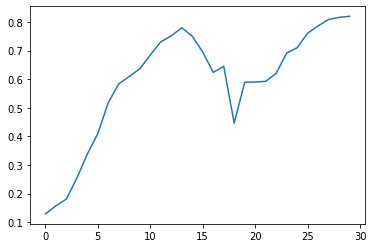

In [10]:
#the code
import numpy as np

import matplotlib.pyplot as plt
from keras import datasets 
#portion 1
(X_train , y_train) , ( X_test , y_test ) = datasets.mnist.load_data( )
n_train = 10000 #number of training data to use
X_train = X_train[:n_train,:,:]
X_test = X_test[:n_train,:,:]
y_train=y_train[:n_train]
X_train = X_train.reshape(n_train, 784)/255
X_test = X_test.reshape(n_train, 784) / 255


n_epoch=30
#portion 6
class Optimizer_StoGradDesc:

    # This is to be used to reset the weights to that gotten after backpropagation
    #this implements the decay learning rate regularization
    def __init__(self, learning_rate=0.1,decay=0, momentum=0.5):
        self.learning_rate = learning_rate
        self.current_learning_rate=learning_rate
        self.decay =decay
        self.counter=0
        self.momentum=momentum
    def pre_update_params(self):
        #this adjusts the learning rate using the decay value
        if self.decay:
            self.current_learning_rate = self.learning_rate* (1. / (1. + self.decay * self.counter))
    def update_params(self, layer):
        
        #this implements the momentum regularization
        if self.momentum:
            if not hasattr(layer,'weight_momentums'):
                layer.weight_momentums=np.zeros_like(layer.weights)
                layer.bias_momentums=np.zeros_like(layer.biases)
            weight_updates=self.momentum* layer.weight_momentums-self.current_learning_rate*layer.dweights
            layer.weight_momentums=weight_updates
        
            bias_updates=self.momentum* layer.bias_momentums-self.current_learning_rate*layer.dbiases
            layer.bias_momentums=bias_updates
        
        else:
            weights_updates = -self.learning_rate * layer.dweights
            biases_updates = -self.learning_rate * layer.dbiases
        # This updates the weight and bias parameter
        layer.weights += weight_updates
        layer.biases += bias_updates        
            
            
    def post_update_params(self):
        self.counter += 1


#portion 2
class Layer_Dense:
    
    def __init__(self,n_inputs,n_neurons):
        #the o.1 is because we want the weight to be less than 1
        self.weights=0.1*np.random.randn(n_inputs,n_neurons)
        #shaped this way so there is no need of transpose
        #intializing biases are 0, were there is a biases for every neuron
        self.biases=np.zeros((1,n_neurons))
    def forward(self,inputs):
        #forward pass, input data is multipled by weight and added to bias
        self.output=np.dot(inputs,self.weights)+self.biases
        self.inputs=inputs
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)
        
#Portion 3
class Activation_Relu:
    def forward(self,inputs):
        self.output=np.maximum(0,inputs)
        
    def backward(self, dvalues):
        # Copy of variables are made
        self.dinputs = dvalues.copy()

        # when input values were negative, we get a gradient 0
        self.dinputs[self.inputs <= 0] = 0
#Portion 4
class Activation_softmax():

    def forward(self,inputs):
        exp_values=np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        self.output=exp_values/np.sum(exp_values,axis=1, keepdims=True)
    def backward(self, dvalues):

            # Create an array with the same shape as our derivatives
            self.dinputs = np.empty_like(dvalues)
            for i, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
                # reshape the output array to a singular column
                single_output = single_output.reshape(-1, 1)
                # Calculate Jacobian matrix of the output 
                jacobian = np.diagflat(single_output)-np.dot(single_output, single_output.T)
                
                self.dinputs[i] = np.dot(jacobian, single_dvalues)
#portion 5
class Categorical_Cross_Entropy_Loss:
    def forward(self,y_true,y_predict):
        #clipping data to prevent division by 0
        y_predict_clipped=np.clip(y_predict,1e-7, 1-1e-7)
        #label is sparse and not 1-hot
        correct_confidences=y_predict_clipped[range(len(y_predict)),y_true]
        losses=-np.log(correct_confidences)
        loss=np.mean(losses)
        #to get the input with the max confidence on each row
        prediction=np.argmax(y_predict, axis=1)
        #accuracy is the average no of time the predicted is equal true value
        accuracy=np.mean(prediction==y_true)
        return loss, accuracy
    def backward(self, dvalues, y_true):

        # Number of samples
        n_samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # we convert labels to one-hot vector as they are sparse
        #np.eye with index is used for this
        y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # To ormalize gradient, we divide by no of samples
        self.dinputs = self.dinputs / n_samples



#no of neurons in output of layer1 is input of layer2
layer1=Layer_Dense(n_inputs=28*28, n_neurons=128)
activation1=Activation_Relu()

layer2=Layer_Dense(n_inputs=128, n_neurons=128)
activation2=Activation_Relu()

layer3=Layer_Dense(n_inputs=128, n_neurons=128)
activation3=Activation_Relu()

layer4=Layer_Dense(n_inputs=128, n_neurons=128)
activation4=Activation_Relu()

layer5=Layer_Dense(n_inputs=128, n_neurons=10)
activation5=Activation_Relu()

softmax1=Activation_softmax()

loss_function=Categorical_Cross_Entropy_Loss()

optimizer=Optimizer_StoGradDesc()
losses,accuracies=[],[]
for epoch in range(n_epoch):

    layer1.forward(X_train)
    activation1.forward(inputs=layer1.output)

    layer2.forward(activation1.output)
    activation2.forward(inputs=layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(inputs=layer3.output)

    layer4.forward(activation3.output)
    activation4.forward(inputs=layer4.output)

    layer5.forward(activation4.output)
    activation5.forward(inputs=layer5.output)


    softmax1.forward(inputs=activation5.output)
    #print(softmax1.output)
    loss,accuracy=loss_function.forward(y_predict=softmax1.output,y_true=y_train)

    
    print('Epoch: ', epoch,'loss ', loss,'accuracy ', accuracy, 'lr')
    losses.append(loss)
    accuracies.append(accuracy)
    
    #Back propagation 

    #the output of softmax is the input of loss#
    #back_softmax=Activation_softmax()
    #back_softmax.output=softmax1.output

    #back_loss_function=Categorical_Cross_Entropy_Loss()
    loss_function.backward(dvalues=softmax1.output ,y_true=y_train)

    softmax1.backward(loss_function.dinputs)

    layer5.backward(dvalues=softmax1.dinputs)
    layer4.backward(dvalues=layer5.dinputs)
    layer3.backward(dvalues=layer4.dinputs)
    layer2.backward(dvalues=layer3.dinputs)
    layer1.backward(dvalues=layer2.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.update_params(layer3)
    optimizer.update_params(layer4)
    optimizer.update_params(layer5)
    optimizer.post_update_params()


# plt.plot(losses)

plt.plot(accuracies)